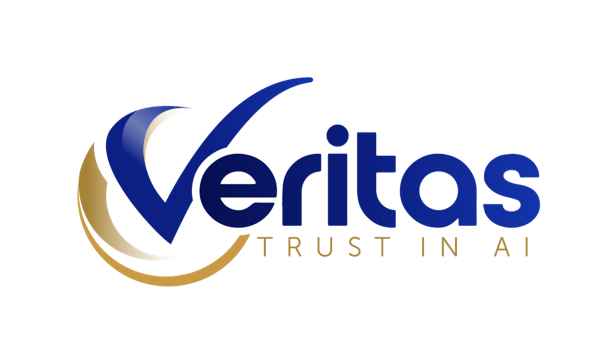

# Veritas Diagnosis Tool Demo : Predictive Underwriting Classification Model 
    
<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a predictive underwriting model and use daignosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p>    
<p>    
    Predictive Underwriting model is a binary classification model to predict whether to award insurance policy by assessing risk. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Fairness & Transparency Diagnosis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 compute trade off analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 compute feature importance analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.6 compute transparency analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.7 save results in json artifact v1<br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4 compute root cause analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.5 perform bias mitigation & rerun fairness assessment <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.7 save results in json artifact v2<br/>
    
</p>

# 1. Loading PUW Data and Model

## Importing Libraries 

In [1]:
#!pip install imblearn
#If facing SSL related errors, the below can be used instead.
#!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org imblearn

In [2]:
import sys
sys.path

['/home/bala_33/Projects/fairness_check/veritastool/veritastool/examples',
 '/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python310.zip',
 '/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10',
 '/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/lib-dynload',
 '',
 '/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages']

In [3]:
import numpy as np
import pandas as pd
import pickle
import sys  
from pathlib import Path
# making veritas available in search path
sys.path.append('../../')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import os
from sklearn.preprocessing import LabelEncoder
SEED = 123
%load_ext autoreload
%autoreload 2

In [10]:
import xgboost as xgb
from sklearn.base import BaseEstimator, ClassifierMixin

In [5]:
from veritastool.model.modelwrapper import ModelWrapper
from veritastool.model.model_container import ModelContainer
from veritastool.usecases.predictive_underwriting import PredictiveUnderwriting

/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for 

## Loading Data  


In [6]:
pth = os.path.abspath('.')

#Load Predictive Underwriting Data
file = os.path.join(pth, 'data',"underwriting_dict.pickle") 
input_file = open(file, "rb")
puw = pickle.load(input_file)
input_file.close()

#Model Contariner Parameters
y_true = np.array(puw["y_test"])
y_pred = np.array(puw["y_pred"])
y_train = np.array(puw["y_train"])
y_prob = puw["y_prob"]
x_train = puw["X_train"]
x_test = puw["X_test"]

Trying to unpickle estimator DecisionTreeClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


### Data Exploration

In [7]:
print("No of rows: {} \nNo. of columns: {}".format(x_train.shape[0],x_train.shape[1]))
x_train.head()

No of rows: 12796 
No. of columns: 20


,BMI,age,annual_premium,new_pol_last_3_years,num_life_policies,num_pa_policies,num_sp_policies,number_exclusions,payout_amount,policy_duration,purchase_recency,tenure,gender,latest_purchase_distribution_channel,latest_purchase_product_category,marital_status,nationality,postcode,race,smoking
0,0,42.0,460.791400,0.0,1.0,0.0,0.0,0.0,5412.073700,75.933840,61.247840,5.135544,1,0,0,1,1,6,1,0
1,0,35.0,935.561460,0.0,1.0,0.0,0.0,1.0,8494.875000,71.933840,71.247840,5.990438,0,0,0,1,1,14,1,0
2,1,44.0,100.901405,0.0,0.0,1.0,2.0,0.0,14150.545000,182.933840,34.914505,15.725551,1,1,1,4,1,12,1,0
3,0,45.0,1243.651400,0.0,1.0,1.0,0.0,1.0,5001.134300,68.933840,61.581173,5.673532,0,0,0,3,1,3,1,0
4,0,35.0,103.511414,1.0,1.0,0.0,0.0,0.0,28.614258,61.933838,38.247840,3.362101,1,0,0,3,1,6,1,0


## Building Model

### Loading & Testing Model

In [8]:
params = {
    'objective': 'binary:logistic',   # For multi-class classification problems    
    'eval_metric': 'logloss',     # Evaluation metric for multi-class classification
    'eta': 0.1,                    # Learning rate
    'max_depth': 3,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of columns when constructing each tree
    'verbosity': 0,                # Verbosity level (0 - silent, 1 - warning, 2 - info, 3 - debug)
}

model_name = "pred_underwriting"
model_type = "classification"

In [16]:
class XGBWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, params=None, th=0.5, classes = [0, 1]):
        self.params = params
        self.model = None
        self.classes_ = classes 
        self.th = th
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.model = xgb.train(self.params, dtrain, num_boost_round=100)
        return self

    def predict(self, x_test):
        test_probs = self.model.predict(xgb.DMatrix(x_test))
        test_preds = np.where(test_probs > self.th, 1, 0)
        return test_preds
    
    def predict_proba(self, x_test):
        return self.model.predict(xgb.DMatrix(x_test))

In [17]:
# class XGBWrapper(ModelWrapper):

#     def __init__(self, model_obj, params, th=0.5,classes = [0, 1]):
#         self.model_obj = model_obj 
#         self.params = params
#         self.classes_ = classes 
#         self.th = th

#     def fit(self, x_train, y_train):
            
#         self.model_obj = self.model_obj.train(self.params, xgb.DMatrix(x_train, label=y_train), 
#         num_boost_round=100)
  
#     def predict(self, x_test):
                
#         test_probs = self.model_obj.predict(xgb.DMatrix(x_test))            
#         # Using bias mitigation thresholds
#         test_preds = np.where(test_probs > self.th, 1, 0)
#         return test_preds
    
#     def predict_proba(self, x_test):
        
#         return self.model_obj.predict(xgb.DMatrix(x_test))

In [18]:
model = XGBWrapper(params=params)
model.fit(x_train, y_train)
model_name = "pred_underwriting"
model_type = "classification"

In [19]:
test_preds_proba = model.predict_proba(x_test)
test_preds = model.predict(x_test)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,test_preds),3)))

Balanced Accuracy: 0.893


In [20]:
test_preds_proba.shape

(4625,)

# 2. Fairness & Transparency Diagnosis

## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning model inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. Predictive Underwriting is showcased in this notebook.

## Set up protected variables

In [21]:
p_grp = {'gender': [1], 'race': [1], 'gender|race':'max_bias'} # Include intersectional fairness
up_grp = {'gender': [0], 'race': [2, 3]}

In [22]:
# Multi-valued protected variable

# Ordinal Mapping
# 'CAUCASIAN' - 0
# 'CHINESE'   - 1
# 'INDIAN'    - 2
# 'MALAY'     - 3
# 'OTHERS'    - 4

x_train['race'].value_counts()

1    10961
2     1133
3      505
4      191
0        6
Name: race, dtype: int64

## Initializing Veritas Library

In [23]:
x_train.shape

(12796, 20)

In [24]:
#Create Model Container 
container = ModelContainer(y_true, p_grp, model_type, model_name, y_pred, y_prob, y_train, x_train=x_train, \
                           x_test=x_test, model_object=model, up_grp=up_grp, pos_label=[1.0])

<h5 align="center">Table 1: Model Container parameters   </h5>

| Var Name    | Category       |Sub-category   | Description   |  Value        |  Compulsory   |
| :---        |    :----:      |   :----:      |          ---: |          ---: |        ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |Yes|
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |Yes|
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])|No|
| x_test      | data           | testing       | test set features | -      |No|
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |No|
| x_train     | data           | training      | train set features |-      |No|
| p_grp       | protected vars |    -          | list of privileged groups| { 'SEX': [ 1 ] , 'MARRIAGE': [ 1 ] }   |Yes|
| pos_label   | labels |    -          | label values considered favorable| [1.0]      |No|
| model_obj   | model          |    -          | model to assess| -      |No|
| model_type  | model          |    -          | type of model | 'credit'    |Yes|
| model_name  | model          |    -          | name of model | 'credit scoring'   |No|
| feature_imp | model          |    -          | list of feature imps for model| -   |No|


In [25]:
#Create Use Case Object
pred_underwriting_obj= PredictiveUnderwriting(model_params = [container], fair_threshold = 80, fair_concern = "inclusive", \
                                        fair_priority = "benefit", fair_impact = "normal", fair_metric_type='ratio',\
                                        tran_row_num=[1,2,3], tran_max_sample = 1000, tran_max_display = 10, \
                                        tran_pdp_feature = ['age','payout_amount'])

<h5 align="center">Table 2: Predictive Underwriting parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_threshold | fairness metric thresolding |threshold used for assessment|floating value between 0 and 1 (treated as actual <br/> value) or 1 and 100 (treated as p%)   |No|
| fair_concern |fair_metric selection| for auto-suggestion: most concerned cohort| "eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection| for auto-suggestion: top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection | for auto-suggestion: impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | for auto-suggestion: type of metric | "difference" or "ratio"  |No|
| fair_metric_name      | metric name |primary fairness metric | "auto" or any of supported ones <br/> like "expected_harm"   |No|
| perf_metric_name      | metric name |primary performance metric |"expected_profit"   |Yes|
| tran_row_num      | transparency parameter |row number for local interpretability plot starting with 1 |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for multi-class model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|
| tran_processed_data      | transparency parameter |sample dataframe for the analysis incase x_train is a string |dataframe    |No|
| tran_processed_label      | transparency parameter |list of y_train(s) for the given tran_processed_data |list    |No|






## Starting Fairness diagnosis

In [26]:
pred_underwriting_obj.evaluate()

Evaluate performance:   0%|          


Class Distribution
	pos_label                                                          82.681%
	neg_label                                                          17.319%


Performance Metrics
	Selection Rate                                             0.816 +/- 0.011
	Accuracy                                                   0.959 +/- 0.006
	Balanced Accuracy                                          0.942 +/- 0.010
	Recall                                                     0.969 +/- 0.005
	Precision                                                  0.982 +/- 0.005
	F1 Score                                                   0.975 +/- 0.004
	True Negative Rate                                         0.915 +/- 0.019
	False Negative Rate                                        0.031 +/- 0.005
	Negative Predictive Value                                  0.859 +/- 0.025
	ROC AUC Score                                              0.988 +/- 0.003
	Log-loss                                     

In [27]:
pred_underwriting_obj.tradeoff()

Tradeoff:   0%|          


------------------------------ 1. gender  ------------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.490
		Best balanced_acc*                                0.941
	 Separated Thresholds
		Privileged Threshold                              0.510
		Unprivileged Threshold                            0.620
		Best balanced_acc*                                0.948
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.422
		Unprivileged Threshold                            0.699
		Best balanced_acc*                                0.938
		*estimated by approximation, subject to the resolution of mesh grid

------------------------------- 2. race  -------------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.490
		Best balanced_acc*                                0.941
	 Separated

<h5 align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table 3: Use of protected variable in model</h5>

| Fairness | Performance | Suggestion      |
| -------- | ---------- | --------------- |
| Worse    | Worse      | Include         |
| Better   | Better     | Exclude         |
| Worse    | Better     | Examine Further |
| Better   | Worse      | Examine Further |

In [28]:
pred_underwriting_obj.feature_importance()

Feature importance:   0%|          




--------------------------------------------------1: Fairness on Race-------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |balanced_acc             |fpr_ratio                |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|race                          |-0.047                   |0.184                    |unfair to unfair (+)|Examine Further   |
----------------------------------------------------------------------------------------------------------------------------
|gender                        |-0.051                   |0.228                    |unfair to unfair (+)|Examine Further   |
-------------------------------------------------------------------------------------------------------------------------

Correlation analysis :   0%|          

Permutation explainer: 1004it [21:41,  1.30s/it]                                                                        



Partial correlation matrix (Most correlated features for race, gender):


,gender,race,num_life_policies,marital_status,payout_amount,nationality,policy_duration,purchase_recency,age
gender,1.000000,0.000000,0.748747,0.022155,0.254725,0.000000,0.581025,0.598700,0.507172
race,0.000000,1.000000,0.010579,0.521701,0.070189,0.099164,0.000000,0.000000,0.000000
num_life_policies,0.748747,0.010579,1.000000,0.000000,0.183955,0.000000,0.411956,0.427258,0.350931
marital_status,0.022155,0.521701,0.000000,1.000000,0.026699,0.031093,0.000000,0.000000,0.008556
payout_amount,0.254725,0.070189,0.183955,0.026699,1.000000,0.000000,0.384212,0.399817,0.350050
nationality,0.000000,0.099164,0.000000,0.031093,0.000000,1.000000,0.033885,0.051466,0.021419
policy_duration,0.581025,0.000000,0.411956,0.000000,0.384212,0.033885,1.000000,0.624398,0.803035
purchase_recency,0.598700,0.000000,0.427258,0.000000,0.399817,0.051466,0.624398,1.000000,0.677455
age,0.507172,0.000000,0.350931,0.008556,0.350050,0.021419,0.803035,0.677455,1.000000


* Surrogate detected for gender (threshold=0.7): num_life_policies


## Starting Transparency Diagnosis

Running transparency for model 1        done      


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


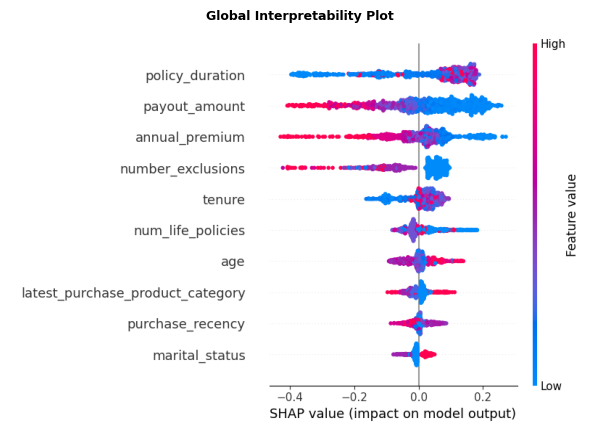

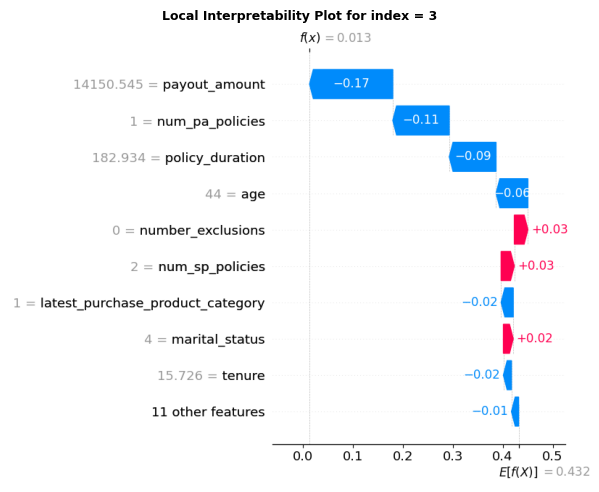

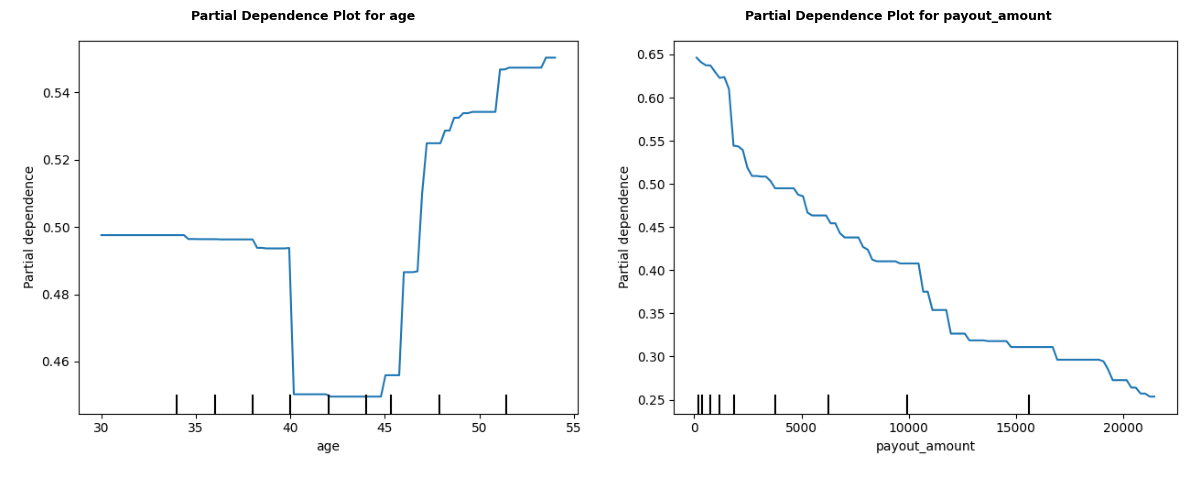

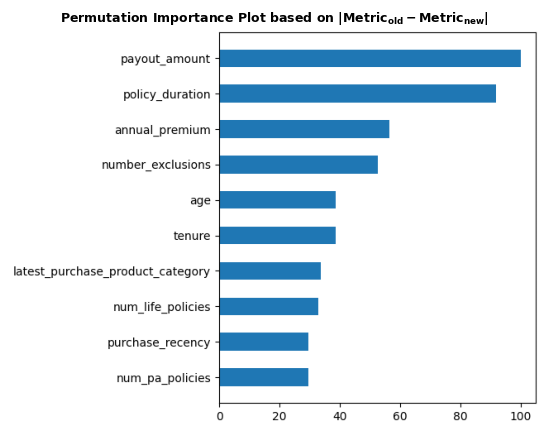

In [29]:
#run the entire transparency analysis 
pred_underwriting_obj.explain()

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| disable | disable any of the transparency analysis |list of valid inputs ['interpret','partial_dep','perm_imp']  |blank list |No|
| local_row_num |row number for local interpretability plot |integer   |last value of tran_row_num |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





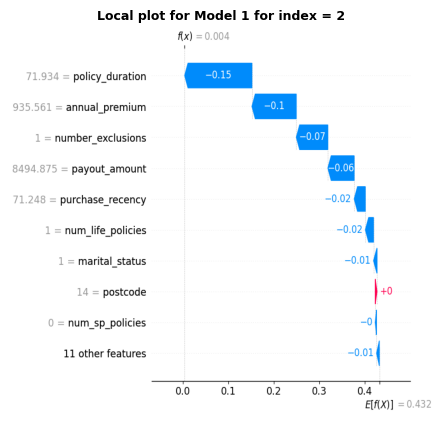

In [30]:
#get the local interpretability plot for specific row index and model
pred_underwriting_obj.explain(local_row_num = 2)

## Compiling Results

In [31]:
pred_underwriting_obj.compile()

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            done      
     performance dynamics               done      
     individual fairness                done      
Running tradeoff                        done      
Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               done      
Running transparency for model 1        done      
Generating model artifact               done
Saved model artifact to model_artifact_pred_underwriting_20230829_1714.json


## Starting Bias Mitigation

Root cause analysis:   0%|          



                              Top 10 contributors towards bias for class '1'      
                         Measured by SHAP-based Demographic Parity on 1003 samples




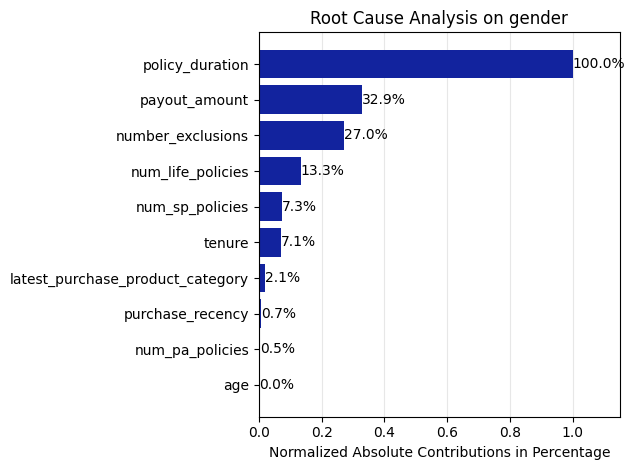

In [32]:
pred_underwriting_obj.rootcause(p_var=['gender'])

In [33]:
mitigated = pred_underwriting_obj.mitigate(p_var=['gender'], method=['threshold', 'reweigh', 'correlate'])

Bias mitigation :   0%|          


*Effective input for p_var = ['gender']

                                Threshold tuning                                

--------------------------------------------------------------------------------
|Protected variable            |Privileged             |Unprivileged           |
--------------------------------------------------------------------------------
|gender                        |0.422                  |0.699                  |
--------------------------------------------------------------------------------


                                   Reweighing                                   

--------------------------------------------------------------------------------
|gender                        |Label                  |Weight                 |
--------------------------------------------------------------------------------
|0                             |0.0                    |1.125                  |
---------------------------------------------------------------

In [34]:
# y_pred can be used to reinitialise the model container and rerun fairness assessment
y_pred_gender_mitigated = mitigated['threshold'][0]

In [35]:
# sample_weights can be used to reinitialise the model container and rerun fairness assessment
sample_weights_mitigated = mitigated['reweigh'][0]

In [36]:
# x_train, x_test can be used to reinitialise the model container and rerun fairness assessment
x_train_mitigated = mitigated['correlate'][0]
x_test_mitigated = mitigated['correlate'][1]

New dataset can be transformed using correlation removal as follows.

In [37]:
# for illustration, a new dataset is being sampled from x_test and y_true
indices = np.random.choice(x_test.index, size=50, replace=False)
x_test_sample = x_test.loc[indices].reset_index(drop=True)
y_true_sample = y_true[indices]
_, _, beta = mitigated['correlate']

In [38]:
transform_mitigated = pred_underwriting_obj.mitigate(p_var=['gender'], method=['correlate'], cr_alpha=0.9, cr_beta=beta, 
                                           transform_x=x_test_sample)

Bias mitigation :   0%|          


*Effective input for p_var = ['gender']

                              Correlation Removal                               

Transforming dataset based on provided and corr_alpha and corr_beta.



In [39]:
# debiased transform_x
transform_mitigated['correlate'][0].head()

,BMI,age,annual_premium,new_pol_last_3_years,num_life_policies,num_pa_policies,num_sp_policies,number_exclusions,payout_amount,policy_duration,purchase_recency,tenure,gender,latest_purchase_distribution_channel,latest_purchase_product_category,marital_status,nationality,postcode,race,smoking
0,-0.053107,40.912534,101.192472,-0.038333,-0.299876,-0.040257,-0.129141,-0.101155,2466.699110,136.240709,32.805556,9.159570,0,0.997819,3.969491,3.004977,0.999933,5.003496,1,0.006260
1,0.067591,35.111320,363.742780,0.048787,0.381661,0.051236,0.164361,0.128743,-371.156859,75.906916,57.204685,6.109695,1,0.002776,0.038830,1.993666,1.000086,-0.004449,1,-0.007967
2,0.067591,47.111320,938.512840,0.048787,1.381661,0.051236,0.164361,1.128743,7360.272141,88.906916,62.538020,7.428654,0,0.002776,4.038830,0.993666,1.000086,14.995551,1,-0.007967
3,1.946893,34.912534,933.242519,-0.038333,2.700124,-0.040257,-0.129141,0.898845,16556.149960,92.240709,57.472221,8.639379,0,-0.002181,3.969491,1.004977,0.999933,12.003496,1,0.006260
4,0.067591,39.111320,726.312780,0.048787,2.381661,0.051236,0.164361,0.128743,-199.291859,71.906916,35.204685,4.628517,1,0.002776,2.038830,0.993666,1.000086,14.995551,1,-0.007967


#### Bias Mitigated Fairness Assessment

In [40]:
# class MitigateWrapper(ModelWrapper):

#     def __init__(self, model_obj, th, classes=[0, 1]):
#         self.model_obj = model_obj
#         self.classes_ = classes        
#         self.th = th

#     def fit(self, X, y):
            
#         self.model_obj.fit(X, y)
  
    
#     def predict(self, x_test):
                
#         test_probs = self.model_obj.predict_proba(x_test)[:, 1] 
                        
#         # Using bias mitigation thresholds
        
#         test_preds = np.where(test_probs > self.th, 1, 0)
        
#         return test_preds
    
    
#     def predict_proba(self, x_test):
        
#         return self.model_obj.predict_proba(x_test)
    
    
def get_row_threshold(X, column, groups, thresholds):
    th = np.zeros(len(X), dtype=float)
    
    for g, t in zip(groups, thresholds):
        group_mask = X[column] == g
        th[group_mask] = t
    return th

th = get_row_threshold(x_test,"gender",[1, 0],[0.431, 0.699])


In [41]:
model_obj = XGBWrapper(model_obj=xgb, params=params, th=th,classes = [0, 1])

Traceback (most recent call last):
  File "/home/bala_33/Softwares/anaconda3/envs/fairness/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6309/2086586378.py", line 1, in <module>
TypeError: XGBWrapper.__init__() got an unexpected keyword argument 'model_obj'


In [ ]:
model_obj.fit(x_train, y_train)

In [ ]:
mitg_y_pred = model_obj.predict(x_test)
print("Balanced Accuracy: {}".format(round(balanced_accuracy_score(y_true,mitg_y_pred),3)))

mitg_y_prob = model_obj.predict_proba(x_test)

In [ ]:
container_mitg = ModelContainer(y_true,  p_grp, model_type, model_name, mitg_y_pred, mitg_y_prob, y_train, x_train=x_train, \
                           x_test=x_test, model_object=model_obj, up_grp=up_grp)

pred_underwriting_obj_mitg = PredictiveUnderwriting(model_params = [container_mitg], fair_threshold = 80, fair_concern = "inclusive", \
                                        fair_priority = "benefit", fair_impact = "normal", fair_metric_type='ratio',\
                                               tran_row_num=[1,2,3], tran_max_sample = 1000, tran_max_display = 10, \
                                                      tran_pdp_feature = ['age','payout_amount'])

pred_underwriting_obj_mitg.evaluate()

In [ ]:
#Call evaluate not just balanced accuracy
pred_underwriting_obj_mitg.compile(disable=['evaluate>perf_dynamic|calibration_curve|individual_fair', \
                                      'feature_importance>correlation', 'explain'])